# Convert TensorFlow Object Detection API Models to Openvino


In [4]:
import os
#path to frozen tensor graph
pbfile="/media/anuj/Work-HDD/openvino_models/open-vino_medium/ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb"

#Path to OpenVino Configuration File describes rules to convert specific TensorFlow topologies.
# You will need Different Configuration File for different topology
configuration_file = '/opt/intel/openvino/deployment_tools/model_optimizer/extensions/front/tf/ssd_v2_support.json'

# SSD Model Configuration File
pipeline = '/media/anuj/Work-HDD/openvino_models/open-vino_medium/ssd_mobilenet_v1_coco_2018_01_28/pipeline.config'

#Using Intel GPU
plugin_device = 'GPU'

#Data Type of the converted Model
# Data type 'FP16' or 'FP32' depends on what device to run the converted model.
# FP16: GPU and MYRIAD
# FP32 CPU and GPU
data_type = None


#Model takes a sized size input I am settting 400*400
img_height= 300

# test Image to Run Infrenece
test_file='/home/anuj/Desktop/test.jpeg'

DATA_TYPE_MAP = {
    'GPU': 'FP16',
    'CPU': 'FP32',
    'MYRIAD': 'FP16'
}

assert plugin_device in DATA_TYPE_MAP, 'Unsupported device: `{}`, not found in `{}`'.format(
    plugin_device, list(DATA_TYPE_MAP.keys()))

if data_type is None:
    data_type = DATA_TYPE_MAP.get(plugin_device)

#define output directory of the converted model
output_dir='/media/anuj/Work-HDD/openvino_models/converted_model'

# Absolute path to `configuration_file`
configuration_file = os.path.join(
    os.environ["INTEL_CVSDK_DIR"], configuration_file)

# Prepare command line argument string.
input_shape = [1, img_height, img_height, 3]
input_shape_str = str(input_shape).replace(' ', '')
input_shape_str

'[1,300,300,3]'

In [19]:
import platform
is_win = 'windows' in platform.platform().lower()

"""
# OpenVINO 2018
if is_win:
    mo_tf_path = 'C:/Intel/computer_vision_sdk/deployment_tools/model_optimizer/mo_tf.py'
else:
    # mo_tf.py path in Linux
    mo_tf_path = '~/intel/computer_vision_sdk/deployment_tools/model_optimizer/mo_tf.py'
"""

# OpenVINO 2019
if is_win:
    mo_tf_path = '"C:\Program Files (x86)\IntelSWTools\openvino_2019.1.133\deployment_tools\model_optimizer\mo_tf.py"'
else:
    # mo_tf.py path in Linux
    mo_tf_path = '/opt/intel/openvino/deployment_tools/model_optimizer/mo_tf.py'


In [20]:
mo_tf_path

'/opt/intel/openvino/deployment_tools/model_optimizer/mo_tf.py'

In [21]:
!python /opt/intel/openvino_2019.1.144/deployment_tools/model_optimizer/mo_tf.py \
    --input_model {pbfile} \
    --output_dir {output_dir} \
    --tensorflow_use_custom_operations_config {configuration_file} \
    --tensorflow_object_detection_api_pipeline_config {pipeline} \
    --input_shape {input_shape_str} \
    --data_type {data_type}

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/media/anuj/Work-HDD/openvino_models/open-vino_medium/ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb
	- Path for generated IR: 	/media/anuj/Work-HDD/openvino_models/converted_model
	- IR output name: 	frozen_inference_graph
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,300,300,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementati

# Running Inference Model

In [5]:
from PIL import Image
import numpy as np
try:
    from openvino import inference_engine as ie
    from openvino.inference_engine import IENetwork, IEPlugin
except Exception as e:
    exception_type = type(e).__name__
    print("The following error happened while importing Python API module:\n[ {} ] {}".format(
        exception_type, e))
    sys.exit(1)

In [6]:
import glob
import os

# Plugin initialization for specified device and load extensions library if specified.
plugin_dir = None
model_xml = '/media/anuj/Work-HDD/openvino_models/converted_model/frozen_inference_graph.xml'
model_bin = '/media/anuj/Work-HDD/openvino_models/converted_model/frozen_inference_graph.bin'
# Devices: GPU (intel), CPU, MYRIAD
plugin = IEPlugin(plugin_device, plugin_dirs=plugin_dir)
# Read IR
net = IENetwork(model=model_xml, weights=model_bin)
assert len(net.inputs.keys()) == 1
assert len(net.outputs) == 1
input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))
# Load network to the plugin
exec_net = plugin.load(network=net)
del net

In [7]:
def pre_process_image(imagePath, img_shape):
    """pre process an image from image path.
    
    Arguments:
        imagePath {str} -- input image file path.
        img_shape {tuple} -- Target height and width as a tuple.
    
    Returns:
        np.array -- Preprocessed image.
    """

    # Model input format
    assert isinstance(img_shape, tuple) and len(img_shape) == 2

    n, c, h, w = [1, 3, img_shape[0], img_shape[1]]
    image = Image.open(imagePath)
    processed_img = image.resize((h, w), resample=Image.BILINEAR)

    processed_img = np.array(processed_img).astype(np.uint8)

    # Change data layout from HWC to CHW
    processed_img = processed_img.transpose((2, 0, 1))
    processed_img = processed_img.reshape((n, c, h, w))

    return processed_img, np.array(image)


In [10]:
# Run inference
img_shape = (img_height, img_height)
processed_img, image = pre_process_image(test_file, img_shape)
res = exec_net.infer(inputs={input_blob: processed_img})

In [11]:
print(res['DetectionOutput'].shape)

(1, 1, 100, 7)


In [13]:
probability_threshold = 0.5

preds = [pred for pred in res['DetectionOutput'][0][0] if pred[2] > probability_threshold]

Predict class label:1, with probability: 0.85
Predict class label:1, with probability: 0.81
Predict class label:18, with probability: 0.84


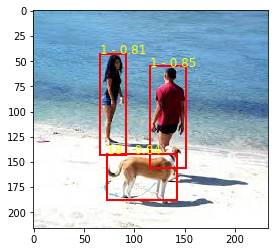

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
ax = plt.subplot(1, 1, 1)
plt.imshow(image)  # slice by z axis of the box - box[0].

for pred in preds:
    class_label = pred[1]
    probability = pred[2]
    print('Predict class label:{:.0f}, with probability: {:.2f}'.format(
        class_label, probability))
    box = pred[3:]
    box = (box * np.array(image.shape[:2][::-1] * 2)).astype(int)
    x_1, y_1, x_2, y_2 = box
    rect = patches.Rectangle((x_1, y_1), x_2-x_1, y_2 -
                             y_1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_1, y_1, '{:.0f} - {:.2f}'.format(class_label,
                                               probability), fontsize=12, color='yellow')